In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import random
from collections import defaultdict
from sklearn import metrics
from time import time
import numpy as np
import re
from nltk.corpus import stopwords
import unicodedata
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import seaborn as sns

In [21]:
# CSV "2022_Urgencia_texto_limpo.csv" with only one column, without header
# read_csv
justificativas_limpo = pd.read_csv("2022_Urgencia_texto_limpo.csv", sep=";", encoding="latin-1")

print(justificativas_limpo.columns)

justificativas_limpo.dropna(inplace=True)

list_justificativa = justificativas_limpo['justificativa_urgencia_viagem'].tolist()

print(len(list_justificativa))

Index(['justificativa_urgencia_viagem'], dtype='object')
384328


In [22]:
list_justificativa = random.sample(list_justificativa, 40000)

print(list_justificativa[:10])

['cobertura solicitada gabinete reitor', 'liberacao recursos', 'periodo definido coordenacao viagem', 'devido atraso processos administrativos', 'lancamento viagem aconteceu prazo previsto virtude proposto apresentado documento convite evento encarramento prazo dia acao', 'devido tramites administrativos razao alteracoes ocorridas decreto', 'diarias passagens nacionais coletivo cad diop autorizado oficio', 'autorizacao proponente liberada dia abril', 'intempestividade solicitacao viagem justifica data definicao autorizacao viagem', 'devido demora envio processo proposto']


In [23]:
n_comp = 50

In [24]:
count_vectorizer = CountVectorizer(max_df=0.9, min_df=0.01)
X_count = count_vectorizer.fit_transform(list_justificativa)


In [25]:
# lsa_count = make_pipeline(TruncatedSVD(n_components=n_comp), Normalizer(copy=False))
# X_count = lsa_count.fit_transform(X_count)
# explained_variance = lsa_count[0].explained_variance_ratio_.sum()

In [26]:
print(X_count.shape)

(40000, 149)


In [27]:
# count the number of entries > 0
count = (X_count[X_count > 0]).shape[1]
min_k = X_count.shape[0] * X_count.shape[1] // count
max_k = min_k * 3
min_k = min_k // 2

# true_k = 300
# cite https://dl.acm.org/doi/pdf/10.1145/99935.99938
print(min_k, max_k)

18 108


In [28]:
sample = list_justificativa
vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.01)
X = vectorizer.fit_transform(sample)

KeyboardInterrupt: 

In [ ]:
lsa = make_pipeline(TruncatedSVD(n_components=n_comp, random_state=42), Normalizer(copy=False))
X = lsa.fit_transform(X)
explained_variance = lsa[0].explained_variance_ratio_.sum()
print(f"Explained variance of the SVD step: {explained_variance:.2f} for {n_comp} components")

Explained variance of the SVD step: 0.65 for 50 components


In [ ]:
res_df = pd.DataFrame(columns=['k', 'inertia', 'silhouette', 'calinski_harabasz', 'davies_bouldin'])

In [ ]:
for k in range(min_k, max_k+1):
    print(f"Running kmeans for k={k}")
    # running kmeans
    model = KMeans(n_clusters=k, init='k-means++', max_iter=200, n_init=1, random_state=42).fit(X)

    labels=model.labels_

    inertia = model.inertia_
    silhouette = metrics.silhouette_score(X, labels, metric='euclidean', sample_size=40000, random_state=42)
    calinski_harabasz = metrics.calinski_harabasz_score(X, labels)
    davies_bouldin = metrics.davies_bouldin_score(X, labels)

    res_df.loc[len(res_df)] = {'k': k, 'inertia': inertia, 'silhouette': silhouette,
                            'calinski_harabasz': calinski_harabasz, 'davies_bouldin': davies_bouldin}

Running kmeans for k=18


KeyboardInterrupt: 

## Elbow Method

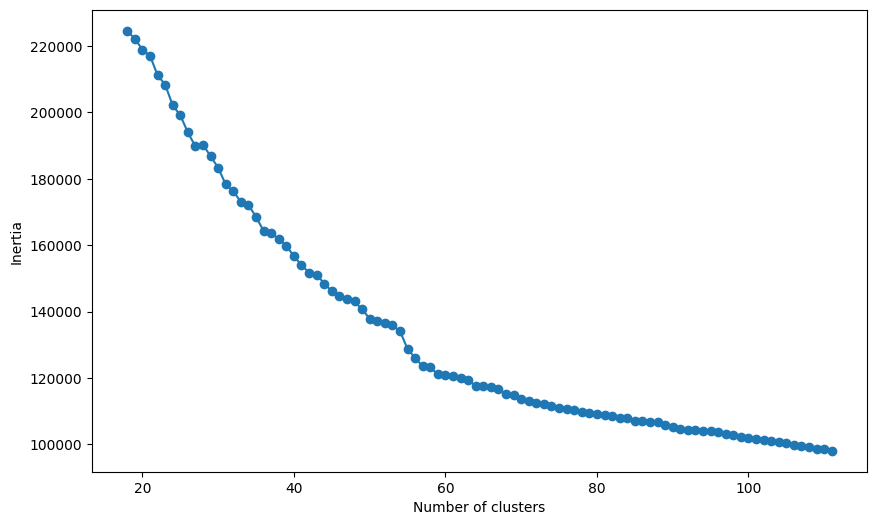

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(res_df['k'], res_df['inertia'], marker='o')

plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

plt.show()


## Silhouette Coefficient

In [ ]:
# max silhouette
print(res_df.loc[res_df['silhouette'].idxmax()])

k                      111.000000
inertia              98123.257449
silhouette               0.338195
calinski_harabasz     8744.967800
davies_bouldin           1.693101
Name: 93, dtype: float64


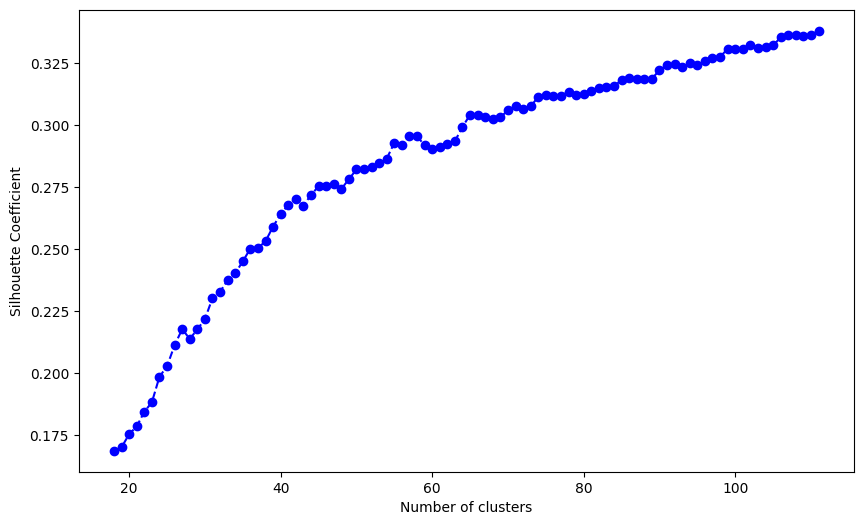

In [ ]:
# 2d plot silhouette for each k

plt.figure(figsize=(10, 6))

plt.plot(res_df['k'], res_df['silhouette'], marker='o', linestyle='--', color='b')

plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')

plt.show()



## Calinski-Harabasz Index

In [ ]:
# max Calinski-Harabasz
print(res_df.loc[res_df['calinski_harabasz'].idxmax()])

k                        57.000000
inertia              123506.582968
silhouette                0.295536
calinski_harabasz     12238.865633
davies_bouldin            1.352600
Name: 39, dtype: float64


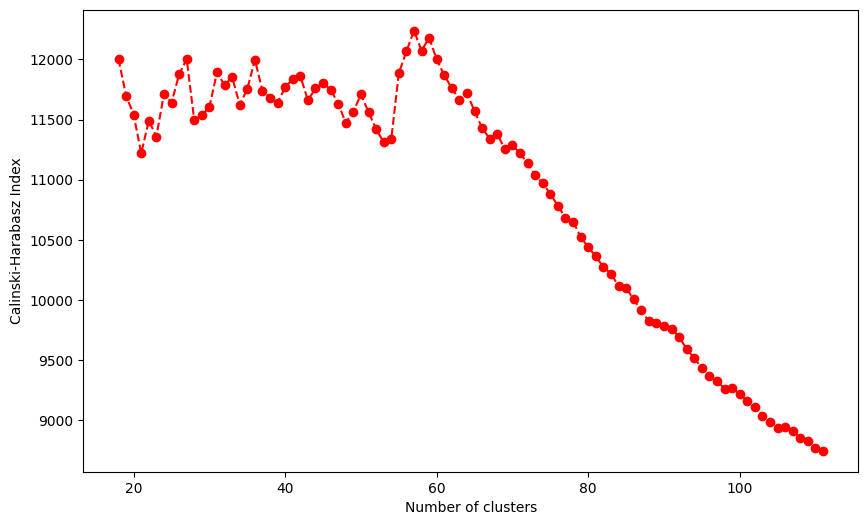

In [ ]:
fig = plt.figure(figsize=(10, 6))

plt.plot(res_df['k'], res_df['calinski_harabasz'], marker='o', linestyle='--', color='r')

plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Index')

plt.show()

## Davies-Bouldin Index

In [ ]:
# max davies_bouldin
print(res_df.loc[res_df['davies_bouldin'].idxmin()])

k                        57.000000
inertia              123506.582968
silhouette                0.295536
calinski_harabasz     12238.865633
davies_bouldin            1.352600
Name: 39, dtype: float64


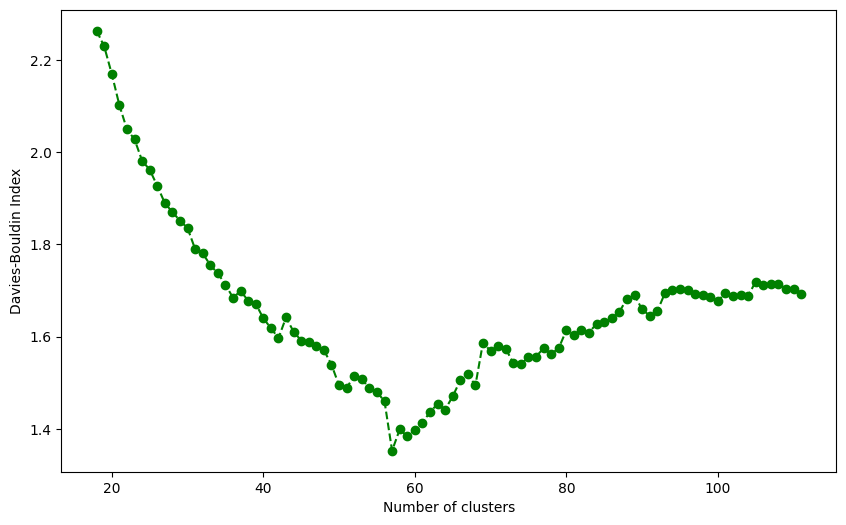

In [ ]:
fig = plt.figure(figsize=(10, 6))

plt.plot(res_df['k'], res_df['davies_bouldin'], marker='o', linestyle='--', color='g')

plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Index')

plt.show()

In [29]:
choosen_k = 57

In [30]:
print(X.shape)

(40000, 50)


In [32]:
model = AgglomerativeClustering(n_clusters=choosen_k, metric='euclidean', linkage='ward').fit(X)

labels = model.labels_

: 

: 

In [ ]:
# print the number of elements for each cluster

print("Number of elements for each cluster")

arr = np.unique(labels, return_counts=True)

# map the cluster number to the number of elements

dict_cluster = dict(zip(arr[0], arr[1]))

clusters = pd.DataFrame.from_dict(dict_cluster, orient='index', columns=['number_of_elements'])

print(clusters)


Number of elements for each cluster
    number_of_elements
0                  326
1                  210
2                  110
3                 1547
4                 1710
5                  132
6                  172
7                  193
8                  126
9                  137
10                 164
11                 110
12                 182
13                 105
14                 114
15                  85
16                  96
17                 117
18                 204
19                 209
20                 125
21                 166
22                 146
23                 150
24                  85
25                 143
26                  96
27                  79
28                 100
29                 125
30                  73
31                 212
32                  74
33                  91
34                  73
35                  68
36                  70
37                 102
38                  81
39                 116
40                  7

<Axes: xlabel='number_of_elements'>

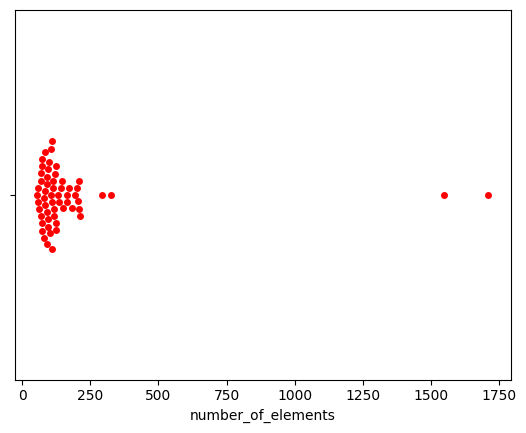

In [ ]:
# 1-D swarmplot
sns.swarmplot(x=clusters["number_of_elements"], color="red")

In [ ]:
# list 10 unique values for each cluster

for i in range(choosen_k):
    print(f"Cluster {i}")
    print("  %d elements" % dict_cluster[i])
    
    set_phrases = set(list_justificativa[i] for i in np.where(labels == i)[0])

    for phr in random.sample(set_phrases, min(20, len(set_phrases))):
        print("  %s" % phr)
    print("\n")

Cluster 0
  326 elements
  aguardando confirmacao participacao servidor
  apoiar redacao ata apresentacoes demandas preparacao documentos durante realizacao evento viagem solicitada antecedencia devido demora confirmacao mudanca data evento
  confirmacao participacao servidores ocorreu dia
  atendimento agenda evento jai
  tratativas funasa confirmando disponibilidade veiculo motorista visto limitacao frota dsei ba realizacao atividades
  ficou confirmado participacao
  devido tramites organizacao realizar acompanhamento furnas
  virtude prazo disponibilidade evento
  devido urgencia servico requer disponibilidade engenheiro vira florianopolis realizar antecedencia solicitacao
  confirmacao roteiro ocorreu retorno servidor
  devido retorno ferias dia servidor confirmar hoje participacao reuniao
  confirmacao reuniao ocorreu presente data
  necessidade participacao atividades localidades diversas inerentes natureza cargo
  necessidade realizacao evento
  motivos disponibilidade agenda l

/tmp/ipykernel_4130/1277250425.py:9: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  for phr in random.sample(set_phrases, min(20, len(set_phrases))):


In [ ]:

#print(clusters.sort_values(by=['cluster']))
# find the centroids
original_space_centroids = lsa[0].inverse_transform(model.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

# for i in range(10):
#     print("#Cluster TOP %d" % (i+1)),
#     print("Cluster %d:" % clusters_count.index[i])

#     for ind in order_centroids[clusters_count.index[i], :10]:
#         print(" %s" % terms[ind])

for i in range(choosen_k):
    print("Cluster %d:" % i),
    print("Cluster size: %d" % clusters_count[clusters_count.index == i].values[0][0])
    for ind in order_centroids[i, :10]:
        print(" %s" % terms[ind])
    print("------------------------------------------")

    for phr in clusters[clusters['cluster']==i]['phrase'].unique()[:20]:
        print("  %s" % phr)
    print("\n")


Cluster 0:
Cluster size: 5849
 autorizada
 viagem
 data
 conforme
 anexo
 missao
 tecnica
 dia
 superior
 carater
------------------------------------------
  remarcacao autorizada conforme documentacao anexada
  remarcacao autorizada
  viagem autorizada conforme aev anexo
  viagem autorizada habil devido exercicio permitido empenho data motivo encontra prazo
  autorizada oficio
  autorizada pro reitoria ensino
  considerando data envio oficio convidando reuniao considerando tratar assunto estrategico interesse cvpaf m crpaf go considerando prejuizo administracao descumprimento prazo emissao passagem viagem autorizada crpaf go
  viagem autorizada superintendente adjunto conforme consta anexo
  conforme prorrogacao autorizada oficio
  viagem autorizada realizada aguardando pagamento diarias
  viagem autorizada chefe ue r
  autorizada data
  viagem tornou urgente devido empenho mesma havia sido autorizada vice presidente voos encontram reservados manter valores emisscao
  viagem autoriza

In [ ]:
#http://datamining.rutgers.edu/publication/internalmeasures.pdf

## Silhouette Coefficient

In [ ]:
metrics.silhouette_score(X, labels, metric='euclidean', sample_size=10000, random_state=42)

0.19208386022028823

## Calinski-Harabasz Index

In [ ]:
metrics.calinski_harabasz_score(X.toarray(), labels)

124.95218373872574

## Davies-Bouldin Index

In [ ]:
metrics.davies_bouldin_score(X.toarray(), labels)

2.31538570263781